## 1. Read Daily Arxiv

In [3]:
import pandas as pd

df = pd.read_pickle("./archive/arxiv.pkl")
df.head()

,Title,Abstract,Announce Type,Guid,Category,Link,Rights,Creator,embeddings
0,Betting on what is neither verifiable nor fals...,Prediction markets are useful for estimating p...,new,oai:arXiv.org:2402.14021v1,"cs.GT,cs.AI,cs.LO",https://arxiv.org/abs/2402.14021,http://creativecommons.org/licenses/by/4.0/,"Abhimanyu Pallavi Sudhir, Long Tran-Thanh","[-0.032012939453125, 0.05810546875, 0.0390625,..."
1,Learning causation event conjunction sequences,This is an examination of some methods that le...,new,oai:arXiv.org:2402.14027v1,cs.LG,https://arxiv.org/abs/2402.14027,http://creativecommons.org/publicdomain/zero/1.0/,Thomas E. Portegys,"[-0.04901123046875, 0.047760009765625, 0.03784..."
2,Partial Search in a Frozen Network is Enough t...,Randomly initialized dense networks contain su...,new,oai:arXiv.org:2402.14029v1,"cs.LG,cs.AI",https://arxiv.org/abs/2402.14029,http://arxiv.org/licenses/nonexclusive-distrib...,"Hikari Otsuka, Daiki Chijiwa, \'Angel L\'opez ...","[-0.03533935546875, 0.041900634765625, 0.03417..."
3,Autoencoder with Ordered Variance for Nonlinea...,This paper presents a novel autoencoder with o...,new,oai:arXiv.org:2402.14031v1,"eess.SY,cs.LG,cs.SY",https://arxiv.org/abs/2402.14031,http://creativecommons.org/licenses/by/4.0/,"Midhun T. Augustine, Parag Patil, Mani Bhushan...","[-0.045654296875, 0.028961181640625, 0.0422668..."
4,VN Network: Embedding Newly Emerging Entities ...,Embedding entities and relations into continuo...,new,oai:arXiv.org:2402.14033v1,"cs.LG,cs.AI",https://arxiv.org/abs/2402.14033,http://arxiv.org/licenses/nonexclusive-distrib...,"Yongquan He, Zihan Wang, Peng Zhang, Zhaopeng ...","[-0.04315185546875, 0.01395416259765625, 0.025..."


## 2. Optimal PCA

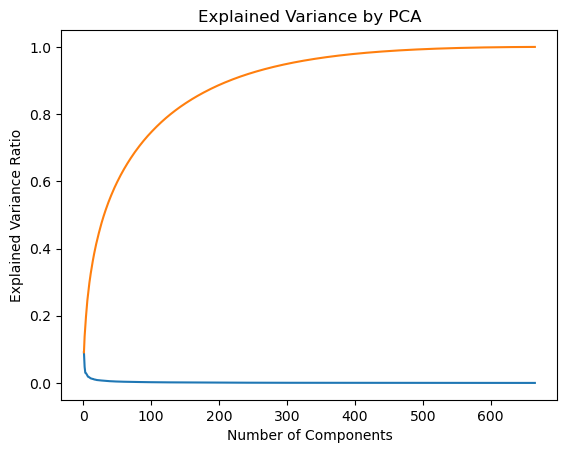

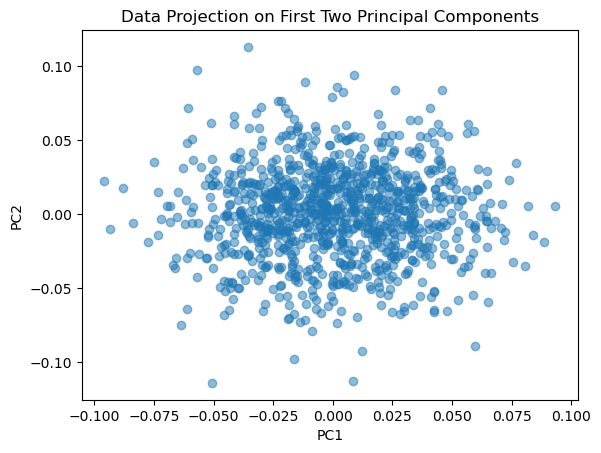

Recommended number of components (elbow method): 639
Recommended number of components (90% threshold): 216


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA


def analyze_pca_variance(data, n_components_max, plot=True):
  pca = PCA(n_components=n_components_max)
  pca.fit(data)

  explained_variance_ratio_ = pca.explained_variance_ratio_
  cumulative_explained_variance_ratio_ = explained_variance_ratio_.cumsum()

  if plot:
    # Plot explained variance
    plt.figure()
    plt.plot(range(1, n_components_max + 1), explained_variance_ratio_)
    plt.plot(range(1, n_components_max + 1), cumulative_explained_variance_ratio_)
    plt.xlabel("Number of Components")
    plt.ylabel("Explained Variance Ratio")
    plt.title("Explained Variance by PCA")
    plt.show()

    # Plot data in 2D for first two components
    plt.figure()
    plt.scatter(pca.components_[0], pca.components_[1], alpha=0.5)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("Data Projection on First Two Principal Components")
    plt.show()

  # Recommendation based on elbow method
  #elbow_index = np.abs(np.diff(explained_variance_ratio_) / explained_variance_ratio_[:-1])
  # Find the index of the maximum elbow index, ensuring it's not the last component
  #recommended_components_ = np.argmax(elbow_index) + 1 if elbow_index.any() else 1

  # Calculate the second derivative
  second_derivative = np.gradient(np.gradient(cumulative_explained_variance_ratio_))
  # Find the index of the maximum of the second derivative
  recommended_components = np.argmax(second_derivative)

  # Alternative recommendation based on 90% explained variance
  threshold = 0.9
  recommended_components_alt = None  # Initialize outside the loop
  for i, ratio in enumerate(cumulative_explained_variance_ratio_):
    if ratio >= threshold:
      recommended_components_alt = i + 1
      break

  print(f"Recommended number of components (elbow method): {recommended_components}")
  print(f"Recommended number of components (90% threshold): {recommended_components_alt}")

  return min(recommended_components, recommended_components_alt)


embeddings = df["embeddings"].to_list()
recommended_components = analyze_pca_variance(embeddings, n_components_max=df.shape[0])


## 3. Optimal KNN

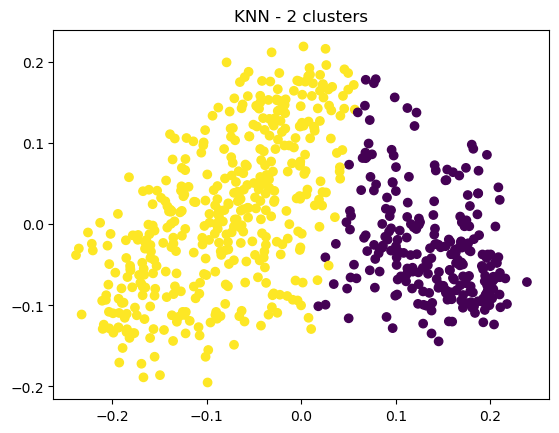

Best number of clusters: 2
Silhouette score: 0.06306470914994487


In [10]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


def optimize_knn(embeddings, n_components):
  pca = PCA(n_components=n_components)
  X = np.array(embeddings)
  X_reduced = pca.fit_transform(X)

  # Define a range of possible cluster numbers
  cluster_range = range(2, 20)

  best_score = -1
  best_k = 0

  # Iterate over different numbers of clusters
  for k in cluster_range:
      # Initialize KMeans with k clusters
      kmeans = KMeans(n_clusters=k, random_state=42)
      # Fit KMeans model to the reduced data
      kmeans.fit(X_reduced)
      # Compute silhouette score
      score = silhouette_score(X_reduced, kmeans.labels_)
      # Check if this is the best silhouette score so far
      if score > best_score:
          best_score = score
          best_k = k
  
  # Plot best kmeans fit
  kmeans = KMeans(n_clusters=best_k)
  kmeans.fit(X_reduced)
  labels = kmeans.labels_

  # Create scatter plot
  plt.figure()
  plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=labels, cmap="viridis")
  plt.title(f"KNN - {best_k} clusters")
  plt.show()

  print("Best number of clusters:", best_k)
  print("Silhouette score:", best_score)

  return labels


# Assuming you have a list of embeddings and summaries
embeddings = df['embeddings'].to_list()  # List of embeddings
summaries = df["Abstract"]   # List of corresponding summaries
labels = optimize_knn(embeddings, recommended_components)
